In [291]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [292]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree

In [293]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [294]:
weight_scale = 1.0
g = 4.0

J_I = weight_scale * g
J_E = weight_scale
delay_mean = 1.5
delay_std = delay_mean * 0.2
v_ext = 0.11

excitatory_type = "ss4"
inhibitory_type = "b"

## Generate network

In [295]:
G = nx.DiGraph()

# Add 1000 nodes
for i in range(1000):
    G.add_node(i)

# Assign 800 nodes as excitatory and 200 as inhibitory
# excitatory_nodes = random.sample(range(1000), 800)
for i in range(800):
        G.nodes[i]['inhibitory'] = False
        G.nodes[i]['ntype'] = excitatory_type
        G.nodes[i]['layer'] = 0

for i in range(800, 1000):
        G.nodes[i]['inhibitory'] = True
        G.nodes[i]['ntype'] = inhibitory_type
        G.nodes[i]['layer'] = 0

# For each node, draw m outgoing edges to random nodes
n_out = 100
for i in range(1000):
    targets = random.sample(range(1000), n_out)
    for target in targets:
        if G.nodes[i]['inhibitory']:
            weight = J_I
        else:
            weight = J_E
        delay = max(0.1, np.random.normal(delay_mean, delay_std))
        G.add_edge(i, target, weight=weight, distance=delay)

In [296]:
# Redistribute lognormally
G = assign_lognormal_weights_for_ntype(G, "ss4", mu=-2.5, sigma=0.85, w_max=10.0)

Text(0.5, 1.0, 'ss4 Weight Distribution after Lognormal Redistribution')

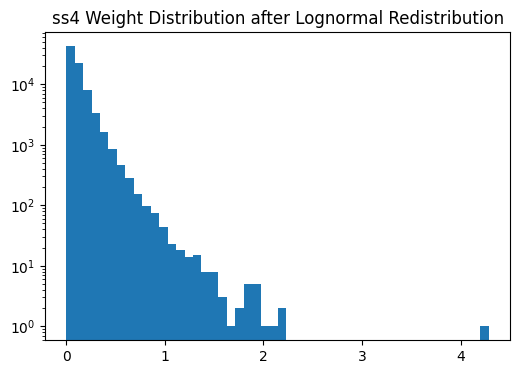

In [297]:
# Plot ss4 weight distribution
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == 'ss4']
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title("ss4 Weight Distribution after Lognormal Redistribution")

## Simulation setup

In [298]:
dt = 0.1

In [299]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [300]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

## Simulation

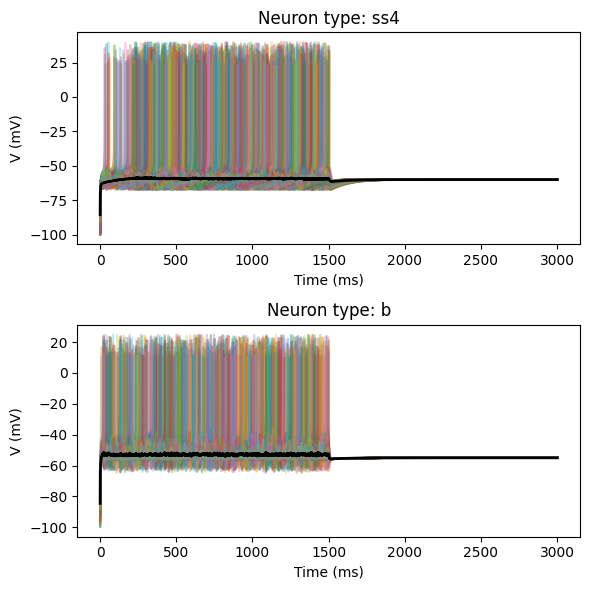

C:\Users\kingt\Dropbox\Programming\NeuralSimV3\NeuroSimV3\python\src\overhead.py:162: RuntimeWarning: invalid value encountered in divide
  fanos = np.where(mu > 0, var / mu, np.nan)


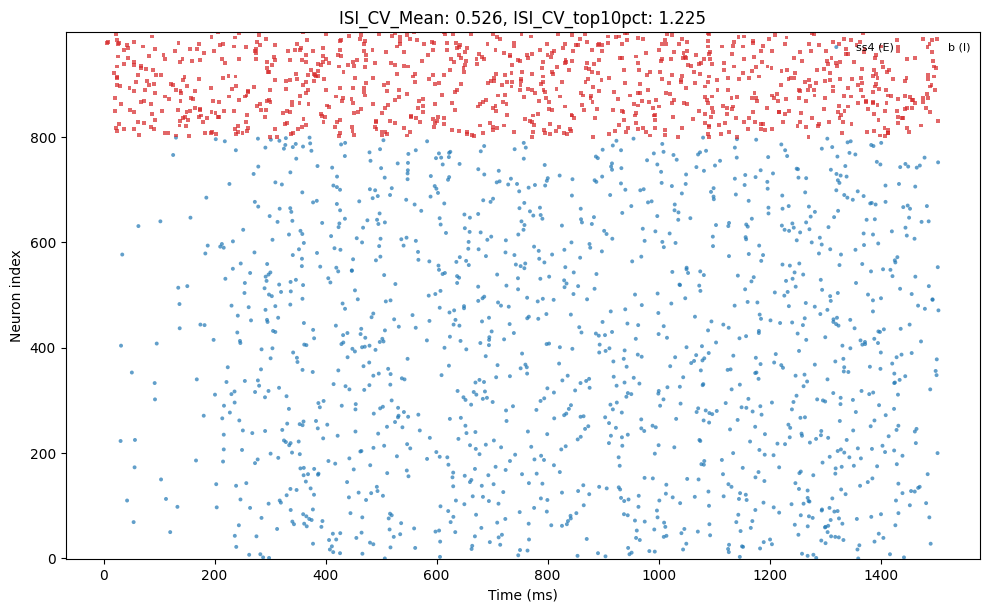

In [301]:

# Randomize initial voltages
Vs = np.random.uniform(-100, -70, size=n_neurons)
us = np.random.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                 enable_plasticity=False, synapse_kwargs={"LT_scale": 1.0}, rise_synapse=False)

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=1.0)

for i in range(15000):
    sensory_spikes = poisson(dt)
    sim.step(spike_ext=sensory_spikes)

for i in range(15000):
    sim.step()

sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=3000.0)

In [305]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=0.0, t_stop_ms=1500.0)

{'rate_mean_Hz': 1.5305646290247314,
 'rate_median_Hz': 1.3332444503699752,
 'rate_p95_Hz': 3.9997333511099256,
 'ISI_CV_median': 0.49319834957812325,
 'ISI_CV_mean': 0.5263828464294472,
 'ISI_CV_mean_E': 0.2757390660934571,
 'ISI_CV_mean_I': 0.7352526633761055,
 'ISI_CV_mean_top10pct': 1.2247650514370336,
 'refractory_violations_per_neuron': 0.0,
 'Fano_median_2ms': 0.9986648865153432,
 'Fano_median_10ms': 0.9932885906040295,
 'Fano_median_50ms': 0.9655172413793107,
 'Fano_median_100ms': 0.9285714285714286,
 'Fano_median_300ms': 0.7500000000000001,
 'Fano_median_500ms': 0.5000000000000001,
 'Fano_median_1000ms': 0.0,
 'mean_noise_corr_2ms': 0.0002591760769341432,
 'mean_noise_corr_10ms': 0.0010627335150422592,
 'mean_noise_corr_50ms': 0.005099042136300227,
 'mean_noise_corr_100ms': 0.010202565271313866,
 'mean_noise_corr_300ms': 0.033964034599764374,
 'mean_noise_corr_500ms': 0.027373202156076845,
 'mean_noise_corr_1000ms': 0.0,
 'participation_frac_mean_300ms': 0.4,
 'participation_f

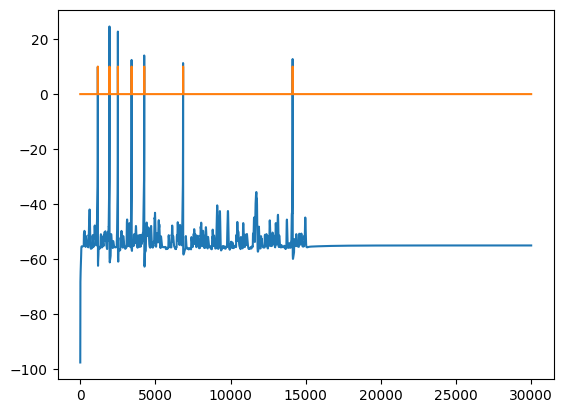

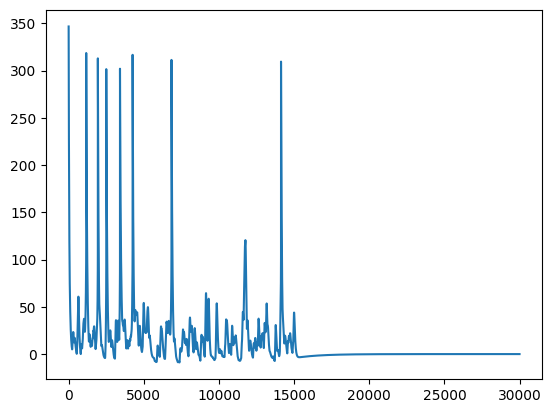

In [303]:
# Plot spikes for one neuron
n_idx = 807
t_first = 0
t_last = -1
plt.plot(np.array(sim.stats.Vs)[t_first:t_last,n_idx])
plt.plot(np.array(sim.stats.spikes)[t_first:t_last,n_idx] * 10)
plt.show()
plt.plot(np.array(sim.stats.us)[t_first:t_last,n_idx])

In [304]:
# connectome.compute_metrics(small_world=False)